In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

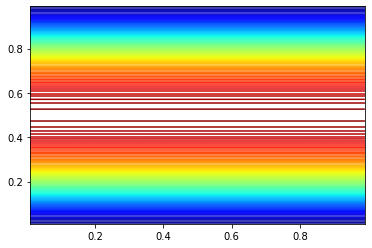

In [2]:
class GaussianCopulaTriL(tfd.TransformedDistribution):
  """Takes a location, and lower triangular matrix for the Cholesky factor."""
  def __init__(self, loc, scale_tril):
    super(GaussianCopulaTriL, self).__init__(
        distribution=tfd.MultivariateNormalTriL(
            loc=loc,
            scale_tril=scale_tril),
        bijector=tfb.NormalCDF(),
        validate_args=False,
        name="GaussianCopulaTriLUniform")


# Plot an example of this.
unit_interval = np.linspace(0.01, 0.99, num=200, dtype=np.float32)
x_grid, y_grid = np.meshgrid(unit_interval, unit_interval)
coordinates = np.concatenate(
    [x_grid[..., np.newaxis],
     y_grid[..., np.newaxis]], axis=-1)

pdf = GaussianCopulaTriL(
    loc=[0., 0.],
    scale_tril=[[1., 0.8], [0., 0.6]],
).prob(coordinates)

# Plot its density.

plt.contour(x_grid, y_grid, pdf, 100, cmap=plt.cm.jet);

In [8]:
a = 2.0
b = 2.0
gloc = 0.
gscale = 1.

x = tfd.Kumaraswamy(a,b)
y = tfd.Gumbel(loc = gloc, scale = gscale)

x_axis_interval = np.linspace(0.01, 0.99, num = 200, dtype = np.float32)
y_axis_interval = np.linspace(-2., 3., num = 200, dtype = np.float32)
x_grid, y_grid = np.meshgrid(x_axis_interval, y_axis_interval)

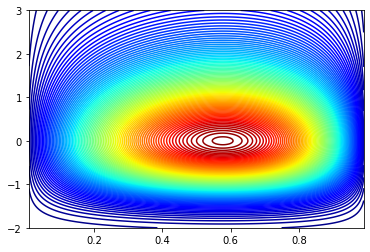

In [9]:
pdf = x.prob(x_grid)*y.prob(y_grid)
plt.contour(x_grid, y_grid, pdf, 100, cmap = plt.cm.jet);

In [10]:
class WarpedGaussianCopula(tfd.TransformedDistribution):
    """Application of a Gaussian Copula on a list of target marginals.
    
    This implements an application of a Gaussian Copula.  Given [x_0,...,x_n]
    which are distributed marginally (with CDF) [F_0, ..., F_n],
    'GaussianCopula' represents an application of the Copula, such that the
    resulting multivariate distribution has the above specified marginals.
    
    The marginals are specified by 'marginal_bijectors': These are bijectors 
    whose 'inverse' encodes the CDF and 'forward the inverse CDF.
    
    bloc_sizes is a 1-D Tensor to determine splits for 'marginal_bjectors'
    length should be same as length of marginal_bijectors'.
    See tfb.Blockwise for details"""
    def __init__(self, loc, scale_tril, marginal_bijectors, block_sizes = None):
        super(WarpedGaussianCopula, self).__init__(
        distribution = GaussianCopulaTriL(loc = loc, scale_tril = scale_tril),
        bijector = tfb.Blockwise(bijectors=marginal_bijectors,
                                block_sizes=block_sizes),
        validate_args = False,
        name = "GaussianCopula")

In [11]:
coordinates = np.concatenate([x_grid[...,np.newaxis], y_grid[...,np.newaxis]], -1)

In [17]:
def create_gaussian_copula(correlation):
    # Use Gaussian Copula to add dependence
    return WarpedGaussianCopula(
    loc = [0.0, 0.],
    scale_tril=[[1., 0.], [correlation, tf.sqrt(1. - correlation**2)]],
    marginal_bijectors=[tfb.Kumaraswamy(a,b),
                      tfb.Invert(tfb.Gumbel(loc=0., scale = 1.))])



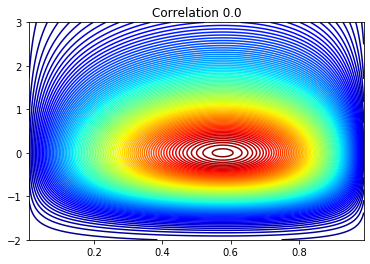

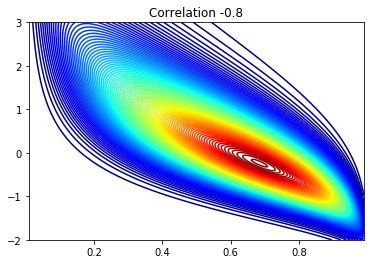

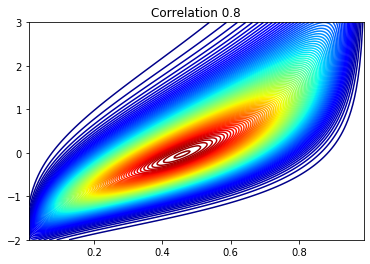

In [18]:
correlations = [0., -0.8, 0.8]
copulas = []
probs = []

for correlation in correlations:
    copula = create_gaussian_copula(correlation)
    copulas.append(copula)
    probs.append(copula.prob(coordinates))
    
for correlation, copula_prob in zip(correlations, probs):
  plt.figure()
  plt.contour(x_grid, y_grid, copula_prob, 100, cmap=plt.cm.jet)
  plt.title('Correlation {}'.format(correlation))

In [19]:
def kumaraswamy_pdf(x):
    return tfd.Kumaraswamy(a, b).prob(np.float32(x))

def gumbel_pdf(x):
    return tfd.Gumbel(gloc, gscale).prob(np.float32(x))

In [20]:
copula_samples = []
for copula in copulas:
  copula_samples.append(copula.sample(10000))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  del sys.path[0]


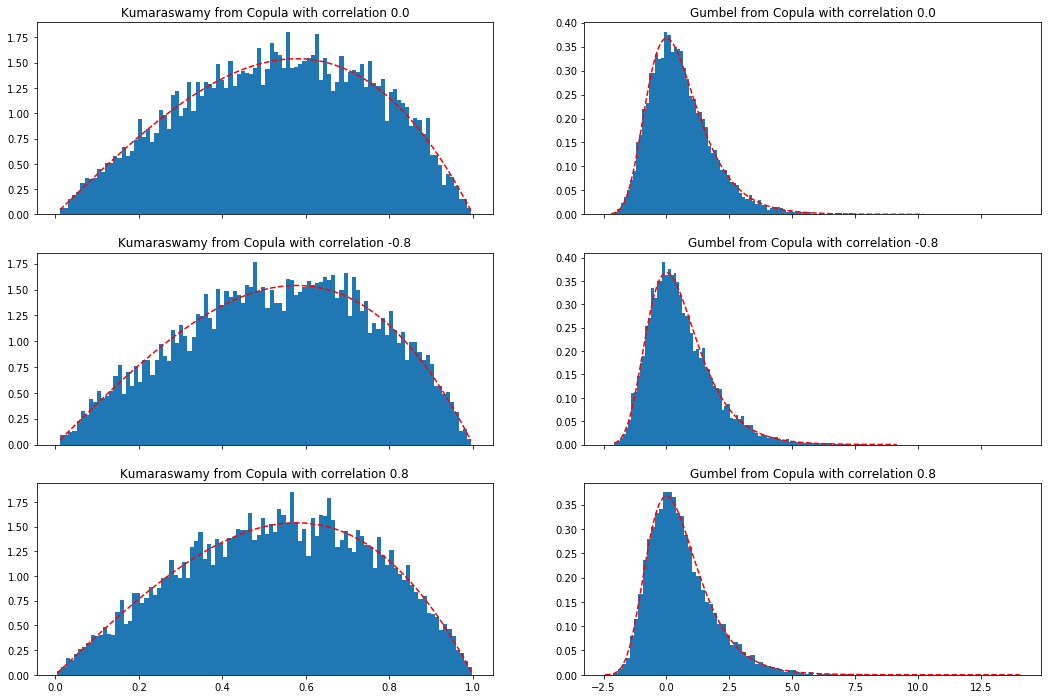

In [23]:
plot_rows = len(correlations)
plot_cols = 2  # for 2  densities [kumarswamy, gumbel]
fig, axes = plt.subplots(plot_rows, plot_cols, sharex='col', figsize=(18,12))

for i, (correlation, copula_sample) in enumerate(zip(correlations, copula_samples)):
  k = copula_sample[..., 0].numpy()
  g = copula_sample[..., 1].numpy()
    
  _, bins, _ = axes[i, 0].hist(k, bins=100, normed=True)
  axes[i, 0].plot(bins, kumaraswamy_pdf(bins), 'r--')
  axes[i, 0].set_title('Kumaraswamy from Copula with correlation {}'.format(correlation))

  _, bins, _ = axes[i, 1].hist(g, bins=100, normed=True)
  axes[i, 1].plot(bins, gumbel_pdf(bins), 'r--')
  axes[i, 1].set_title('Gumbel from Copula with correlation {}'.format(correlation))